## Clasificador de frutas

---



###Primer paso: subir dataset desde gitlab (repo mio)

In [1]:
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

dataset_url = "https://gitlab.com/utn944026/fruit_dataset/-/raw/main/frutas.zip?inline=false"
data_dir = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
print (data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))

print("Cantidad de imágenes detectadas: ",image_count)


/root/.keras/datasets/frutas
Cantidad de imágenes detectadas:  4849


Muestra de una imagen de ejemplo del dataset para corroborar que se cargó correctamente:

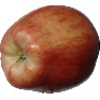

In [2]:
Manzana = list(data_dir.glob('Manzana/*'))
PIL.Image.open(str(Manzana[0]))

### Segundo Paso: Creación el dataset utilizando las funcionalidades de Keras


In [3]:
#Definimos algunos parámetros
batch_size = 3880    #Al ser un dataset chico, usamos Batch Descendent
img_height = 64
img_width = 64

Separación del dataset: 80% Entrenamiento, 20% Validación.


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4849 files belonging to 7 classes.
Using 3880 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4849 files belonging to 7 classes.
Using 969 files for validation.


Veamos las clases que detectó:


In [6]:
class_names = train_ds.class_names
print(class_names)

['Banana', 'Limon', 'Mandarina', 'Manzana', 'Naranja', 'Pera', 'Tomate']


###Visualización de los datos

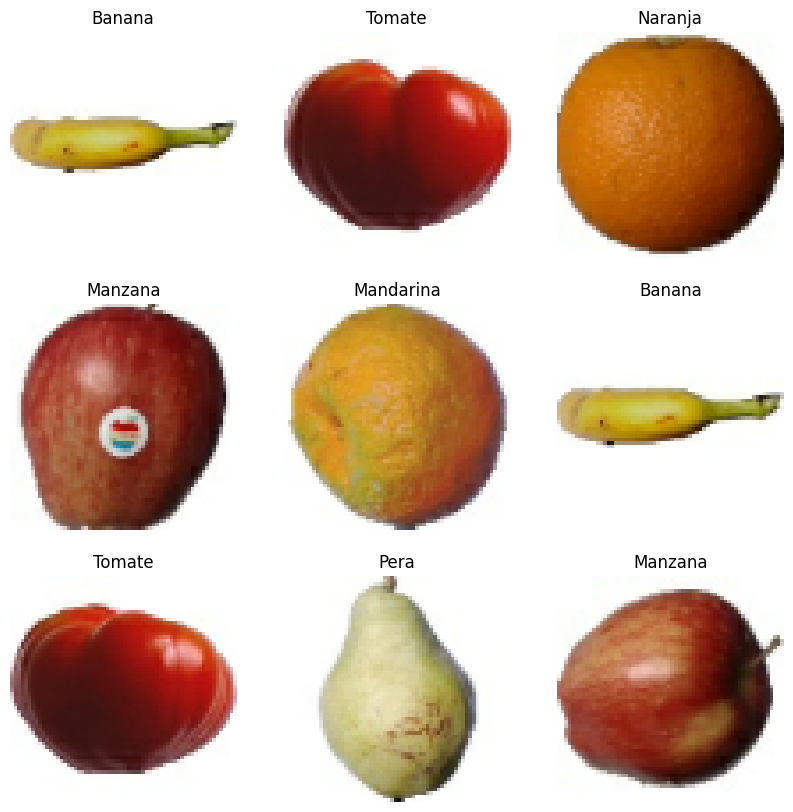

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(3880, 64, 64, 3)
(3880,)



###Tercer paso: Configuración del dataset

- `Dataset.cache` mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época (epoch). Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras el modelo se entrena. Si el conjunto de datos es demasiado grande para caber en la memoria, también se puede usar este método para crear un caché en disco de alto rendimiento.
- `Dataset.prefetch` superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Cuarto paso: Estandarización de los datos

Se estandarizan los valores de los canales RGB de `[0, 255]` a `[0, 1]` usando `tf.keras.layers.Rescaling`:

In [10]:
#normalization_layer = layers.Rescaling(1./255)

Existen dos formas de normalizar los valores de entrada: La primera es aplicandole este rescaling al dataset de una mediante la función Dataset.map, o utilizando esta capa de normalización en la misma red neuronal. Para que quede de una forma más prolija aplico la segunda forma. De igual manera, para hacer de la primer forma se debería utilizar:

In [11]:
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]

#print(np.min(first_image), np.max(first_image))

### Quinto paso: Creación del modelo

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), input_shape = (64, 64, 3), padding = "same", activation = "relu"),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Flatten(),
  layers.Dense(256, activation = "relu"),
  layers.Dense(num_classes)
])

### Sexto paso: Compilación del modelo

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9

### Septimo paso: Entrenamiento del modelo

In [15]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
1/1 [==============================] - 14s 14s/step - loss: 1.9550 - accuracy: 0.1309 - val_loss: 1.8908 - val_accuracy: 0.2157
Epoch 2/30
1/1 [==============================] - 0s 272ms/step - loss: 1.8961 - accuracy: 0.1997 - val_loss: 1.8606 - val_accuracy: 0.2157
Epoch 3/30
1/1 [==============================] - 0s 274ms/step - loss: 1.8627 - accuracy: 0.1997 - val_loss: 1.8102 - val_accuracy: 0.2157
Epoch 4/30
1/1 [==============================] - 0s 273ms/step - loss: 1.8135 - accuracy: 0.1997 - val_loss: 1.7397 - val_accuracy: 0.2157
Epoch 5/30
1/1 [==============================] - 0s 274ms/step - loss: 1.7455 - accuracy: 0.1997 - val_loss: 1.6477 - val_accuracy: 0.3860
Epoch 6/30
1/1 [==============================] - 0s 272ms/step - loss: 1.6570 - accuracy: 0.3691 - val_loss: 1.5346 - val_accuracy: 0.6151
Epoch 7/30
1/1 [==============================] - 0s 277ms/step - loss: 1.5457 - accuracy: 0.6188 - val_loss: 1.4046 - val_accuracy: 0.7100
Epoch 8/30
1/1 [=====

### Octavo paso: Visualización de resultados

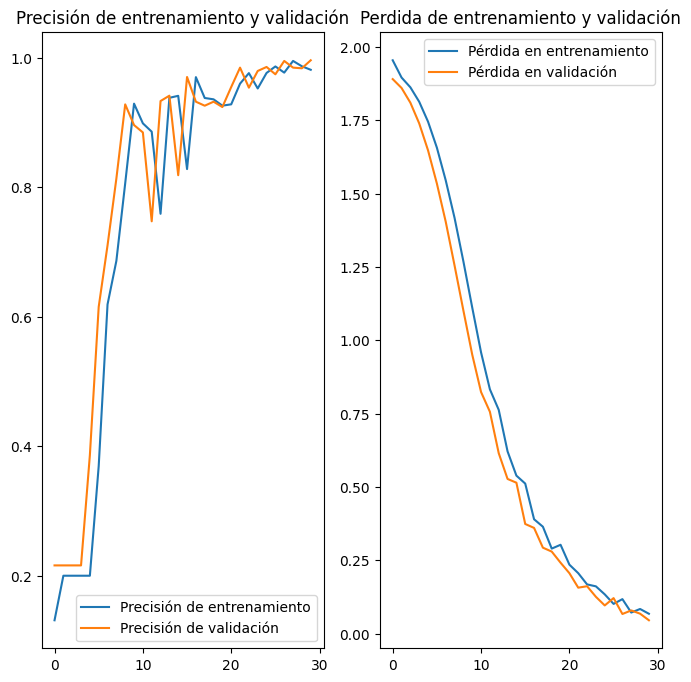

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida en entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en validación')
plt.legend(loc='upper right')
plt.title('Perdida de entrenamiento y validación')
plt.show()

### Noveno paso: Predicción en una nueva imágen

Vamos a probar el modelo con otras imágenes

1/1 [==============================] - 0s 19ms/step


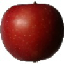

Esta imagen pertenece a la clase Manzana. Probabilidad: 83.42370390892029 %


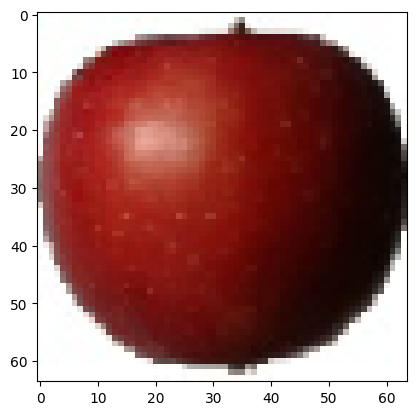

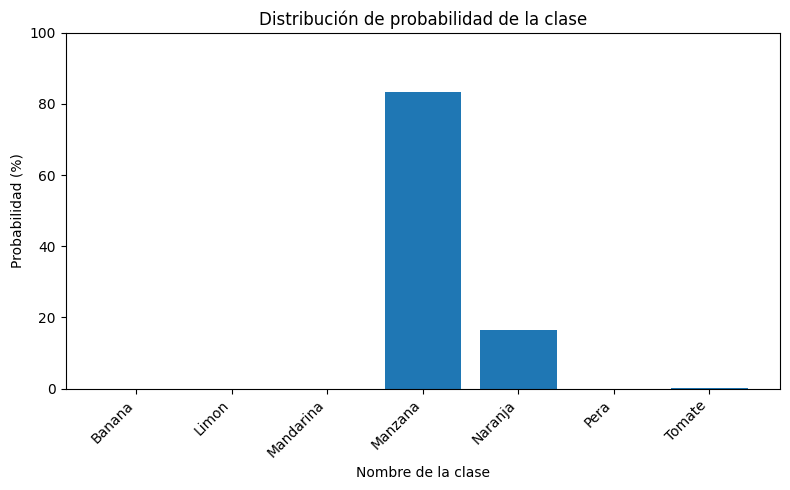

In [39]:
fruta_url = "https://gitlab.com/utn944026/fruit_dataset/-/raw/main/107_100.jpg?inline=false"
fruta_path = tf.keras.utils.get_file('Fruta', origin=fruta_url)

img = tf.keras.utils.load_img(
    fruta_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

display(img)
print(
    "Esta imagen pertenece a la clase {}. Probabilidad: {} %"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.imshow(img)

plt.figure(figsize=(8, 5))
plt.bar(class_names, score*100)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nombre de la clase')
plt.ylabel('Probabilidad (%)')
plt.title('Distribución de probabilidad de la clase')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step


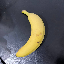

Esta imagen pertenece a la clase Banana. Probabilidad: 99.99603033065796 %


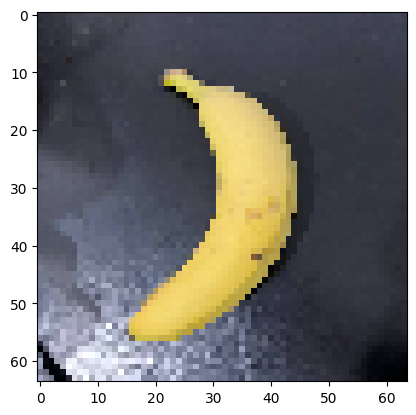

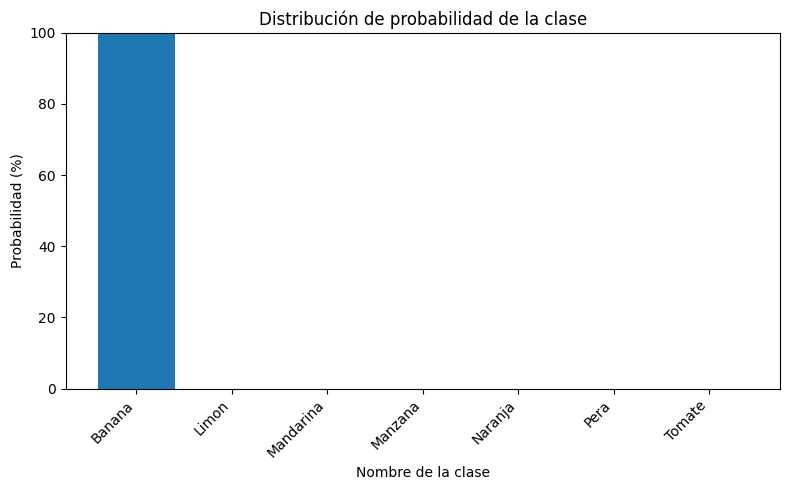

In [40]:
fruta1_url = "https://gitlab.com/utn944026/fruit_dataset/-/raw/main/banana.jpg?inline=false"
fruta1_path = tf.keras.utils.get_file('Fruta1', origin=fruta1_url)

img1 = tf.keras.utils.load_img(
    fruta1_path, target_size=(img_height, img_width)
)
img1_array = tf.keras.utils.img_to_array(img1)
img1_array = tf.expand_dims(img1_array, 0) # Create a batch

predictions1 = model.predict(img1_array)
score1 = tf.nn.softmax(predictions1[0])

display (img1)
print(
    "Esta imagen pertenece a la clase {}. Probabilidad: {} %"
    .format(class_names[np.argmax(score1)], 100 * np.max(score1))
)
plt.imshow (img1)

plt.figure(figsize=(8, 5))
plt.bar(class_names, score1*100)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nombre de la clase')
plt.ylabel('Probabilidad (%)')
plt.title('Distribución de probabilidad de la clase')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 19ms/step


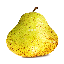

Esta imagen pertenece a la clase Pera. Probabilidad: 63.57131004333496 %


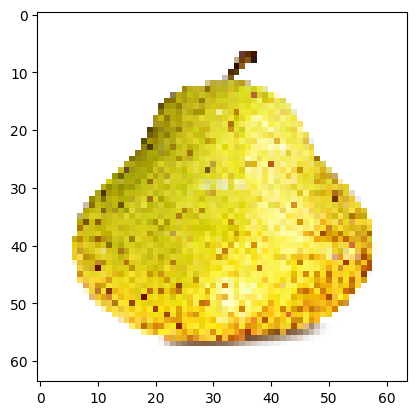

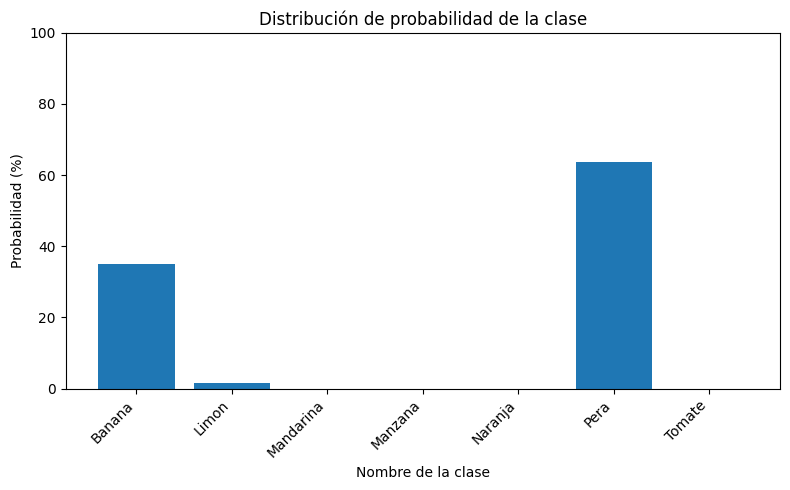

In [41]:
fruta2_url = "https://gitlab.com/utn944026/fruit_dataset/-/raw/main/pera.jpg?inline=false"
fruta2_path = tf.keras.utils.get_file('Fruta2', origin=fruta2_url)

img2 = tf.keras.utils.load_img(
    fruta2_path, target_size=(img_height, img_width)
)
img2_array = tf.keras.utils.img_to_array(img2)
img2_array = tf.expand_dims(img2_array, 0) # Create a batch

predictions2 = model.predict(img2_array)
score2 = tf.nn.softmax(predictions2[0])

display (img2)
print(
    "Esta imagen pertenece a la clase {}. Probabilidad: {} %"
    .format(class_names[np.argmax(score2)], 100 * np.max(score2))
)
plt.imshow(img2)

plt.figure(figsize=(8, 5))
plt.bar(class_names, score2*100)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nombre de la clase')
plt.ylabel('Probabilidad (%)')
plt.title('Distribución de probabilidad de la clase')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

El modelo predice las clases como se espera.